# Proyecto práctico - Acrobot


> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1:
*   Alumno 2:
*   Alumno 3:
*   Alumno 4:






---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.


---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```


---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [2]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount=r''
drive_root = mount + r"C:\Users\david\OneDrive - Greens Power Products S.L\Documents\RL\proyecto"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [3]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

Archivos en el directorio: 
['.ipynb_checkpoints', 'Proyecto_Opcion_2.ipynb', 'Proyecto_Opcion_2_pruebas.ipynb', 'pruebas', 'Untitled.ipynb']


---
### 1.4. Instalar librerías necesarias

if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.8
  %pip install protobuf==3.20.*
else:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.
  %pip install optuna

---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será [Acrobot-v1](https://www.gymlibrary.dev/environments/classic_control/acrobot/) y el algoritmo que usaremos será _DQN_.
- Se proporciona una solución base ("BASELINE"), que servirá como punto de partida para los experimentos.

Este proyecto práctico consta de tres partes:

1.   Mejorar la solución base basada en e-greedy DQN: hyper-parametros, arquitectura, etc.
2.   Investigar y detallar (a nivel teórico) las diferencias de este agente con: **Bolzman Policy**, **Double DQN**, **Dueling DQN**.
3.   Comparar, empleando keras-rl, el rendimiento (recomensa total, velocidad de convergencia, etc.) con estos métodos más avanzados.
4.   Justificar los hyper-parámetros empleados para cada configuración. Como afecta a la performance, por ejemplo, ¿un cámbio en el scheduler de épsilon? ¿Cómo afecta aumentar/disminuír la actualización de la target network?¿Cómo afecta aumentar/disminuír el tamaño de la memoria?
5. Conclusiones y discusion.

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada.

IMPORTANTE:

* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [38]:
# Imports generales
from __future__ import division
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Imports de entorno
import gym

# Imports de deep learning
import tensorflow as tf

# Imports de keras-rl
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger # Para poder comparar curvas de aprendizaje

from tensorflow.keras.callbacks import Callback

#### Configuración entorno

In [5]:
# Configuración enviroment
env_name = 'Acrobot-v1'
env = gym.make(env_name)

# Semillas de reproducibilidad
np.random.seed(123)
env.seed(123)

# Set observations and actions spaces
n_obs = env.observation_space
nb_actions = env.action_space.n

---
### BASELINE PROPUESTO

Antes de empezar vamos a definir un callback que nos permita guardar los mejores pesos

In [8]:
# Para guardar el mejor modelo
class BestModelSaver(Callback):
    def __init__(self, filepath, monitor='episode_reward', mode='max'):
        self.filepath = filepath
        self.monitor = monitor
        self.best = -np.inf if mode == 'max' else np.inf
        self.mode = mode

    def on_episode_end(self, episode, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            return

        if (self.mode == 'max' and current > self.best) or (self.mode == 'min' and current < self.best):
            print(f"\nEpisode {episode}: {self.monitor} improved from {self.best:.4f} to {current:.4f}. Saving weights.")
            self.best = current
            self.model.save_weights(self.filepath, overwrite=True)        

In [9]:
# Hyper-params
memory_limit = 10000
window_length = 4
max_eps, min_eps, test_eps = 1.0, 0.1, 0.05
steps_exploration = 25000
steps_warmup = 100
gamma = 0.99
target_model_update = 1000
train_interval = 4
learning_rate = 1e-3
nb_steps = 50000
batch_size = 128

# Modelo simple
input_shape = (n_obs)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(nb_actions))
model.add(tf.keras.layers.Activation('linear'))
print(model.summary())

# Memory
memory = SequentialMemory(limit=memory_limit, window_length=window_length)

# Policy
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=max_eps, value_min=min_eps,
                              value_test=test_eps, nb_steps=steps_exploration)
# Agente
egreed_dqn = DQNAgent(model=model, nb_actions=nb_actions,
               policy=policy, memory=memory,
               nb_steps_warmup=steps_warmup, gamma=gamma,
               target_model_update=target_model_update,
               train_interval=train_interval, batch_size=batch_size)

# Compilar
egreed_dqn.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])

# Callbacks
model_name = 'baseline_'
# Guardar los mejores pesos
best_filename = f'best_{model_name}{env_name}_weights.h5f'
best_model_saver = BestModelSaver(
    filepath=best_filename,
    monitor='episode_reward',
    mode='max' 
)
# Guardar el log
log_filename = f'{model_name}{env_name}_log.json'
callbacks = [FileLogger(log_filename, interval=100), best_model_saver]

# Entrenar
egreed_dqn.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Salvar pesos finales
egreed_dqn.save_weights( f'final_{model_name}{env_name}_weights.h5f', overwrite=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense (Dense)               (None, 16)                400       
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 activation_2 (Activation)   (None, 16)                0

C:\Users\david\anaconda3\envs\miar_rl\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\david\anaconda3\envs\miar_rl\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')



Episode 0: episode_reward improved from -inf to -500.0000. Saving weights.
   500/50000: episode: 1, duration: 5.674s, episode steps: 500, steps per second:  88, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.012 [0.000, 2.000],  loss: 0.069929, mae: 0.405227, mean_q: -0.259995, mean_eps: 0.989200
  1000/50000: episode: 2, duration: 4.524s, episode steps: 500, steps per second: 111, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.990 [0.000, 2.000],  loss: 0.011715, mae: 0.445532, mean_q: -0.546992, mean_eps: 0.973072
  1500/50000: episode: 3, duration: 3.679s, episode steps: 500, steps per second: 136, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.076 [0.000, 2.000],  loss: 0.034982, mae: 1.051247, mean_q: -1.428106, mean_eps: 0.955072
  2000/50000: episode: 4, duration: 4.151s, episode steps: 500, steps per second: 120, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean 

In [81]:
# Testear los mejores pesos
egreed_dqn.load_weights(f"best_baseline_{env_name}_weights.h5f")
egreed_dqn.test(env, nb_episodes=10, visualize=False)

Testing for 10 episodes ...
Episode 1: reward: -126.000, steps: 127
Episode 2: reward: -130.000, steps: 131
Episode 3: reward: -166.000, steps: 167
Episode 4: reward: -130.000, steps: 131
Episode 5: reward: -140.000, steps: 141
Episode 6: reward: -147.000, steps: 148
Episode 7: reward: -120.000, steps: 121
Episode 8: reward: -133.000, steps: 134
Episode 9: reward: -135.000, steps: 136
Episode 10: reward: -139.000, steps: 140


In [17]:
# Añadimos una función para visualizar datos del log
def visualizar_log(log_filename):
    # Cargar métricas del archivo JSON
    with open(log_filename, 'r') as file:
        log_data = json.load(file)
    
    loss = log_data['loss']
    mae = log_data['mae']
    episode_reward = log_data['episode_reward']
    steps = log_data['nb_steps']
    episode_steps = log_data['nb_episode_steps']
    episodes = log_data['episode']
    reward=log_data['episode_reward']
    df = pd.DataFrame({
        'episode': episodes,
        'reward': reward
    })
    
    df['reward_moving_avg'] = df['reward'].rolling(10).mean()
    
    # Crear una figura con subgráficas 4x2 (4 filas, 2 columnas)
    fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # Tamaño ajustado para mejor distribución
    
    # Gráfica 1: Loss over Steps
    axs[0, 0].plot(steps, loss)
    axs[0, 0].set_title('Loss over Steps')
    axs[0, 0].set_xlabel('Steps')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].grid()
    
    # Gráfica 2: Mae over Steps
    axs[0, 1].plot(steps, mae)
    axs[0, 1].set_title('MAE over Steps')
    axs[0, 1].set_xlabel('Steps')
    axs[0, 1].set_ylabel('MAE')
    axs[0, 1].grid()
    
    # Gráfica 3: Steps per Episode
    axs[1, 0].plot(episodes, episode_steps)
    axs[1, 0].set_title('Steps per Episode')
    axs[1, 0].set_xlabel('Episodes')
    axs[1, 0].set_ylabel('Steps')
    axs[1, 0].grid()
    
    # Gráfica 4: Rewards with Moving Average
    axs[1, 1].plot(df['episode'], df['reward'], label='Reward')
    axs[1, 1].plot(df['episode'], df['reward_moving_avg'], label='Moving Avg', linestyle='--')
    axs[1, 1].set_title('Rewards with Moving Average')
    axs[1, 1].set_xlabel('Episodes')
    axs[1, 1].set_ylabel('Rewards')
    axs[1, 1].legend()
    axs[1, 1].grid()
    
    # Información de métricas agregadas
    text_info = f"Average reward: {df['reward'].mean():.2f}\nMax reward: {df['reward'].max():.2f}\nMin reward: {df['reward'].min():.2f}"
    axs[2, 0].axis('off')  # Desactivar el marco de la subgráfica
    axs[2, 0].text(0.1, 0.5, text_info, fontsize=12, verticalalignment='center')
    
    # Desactivar las subgráficas vacías
    axs[2, 1].axis('off')  # Otra gráfica vacía
    axs[3, 0].axis('off')
    axs[3, 1].axis('off')
    
    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

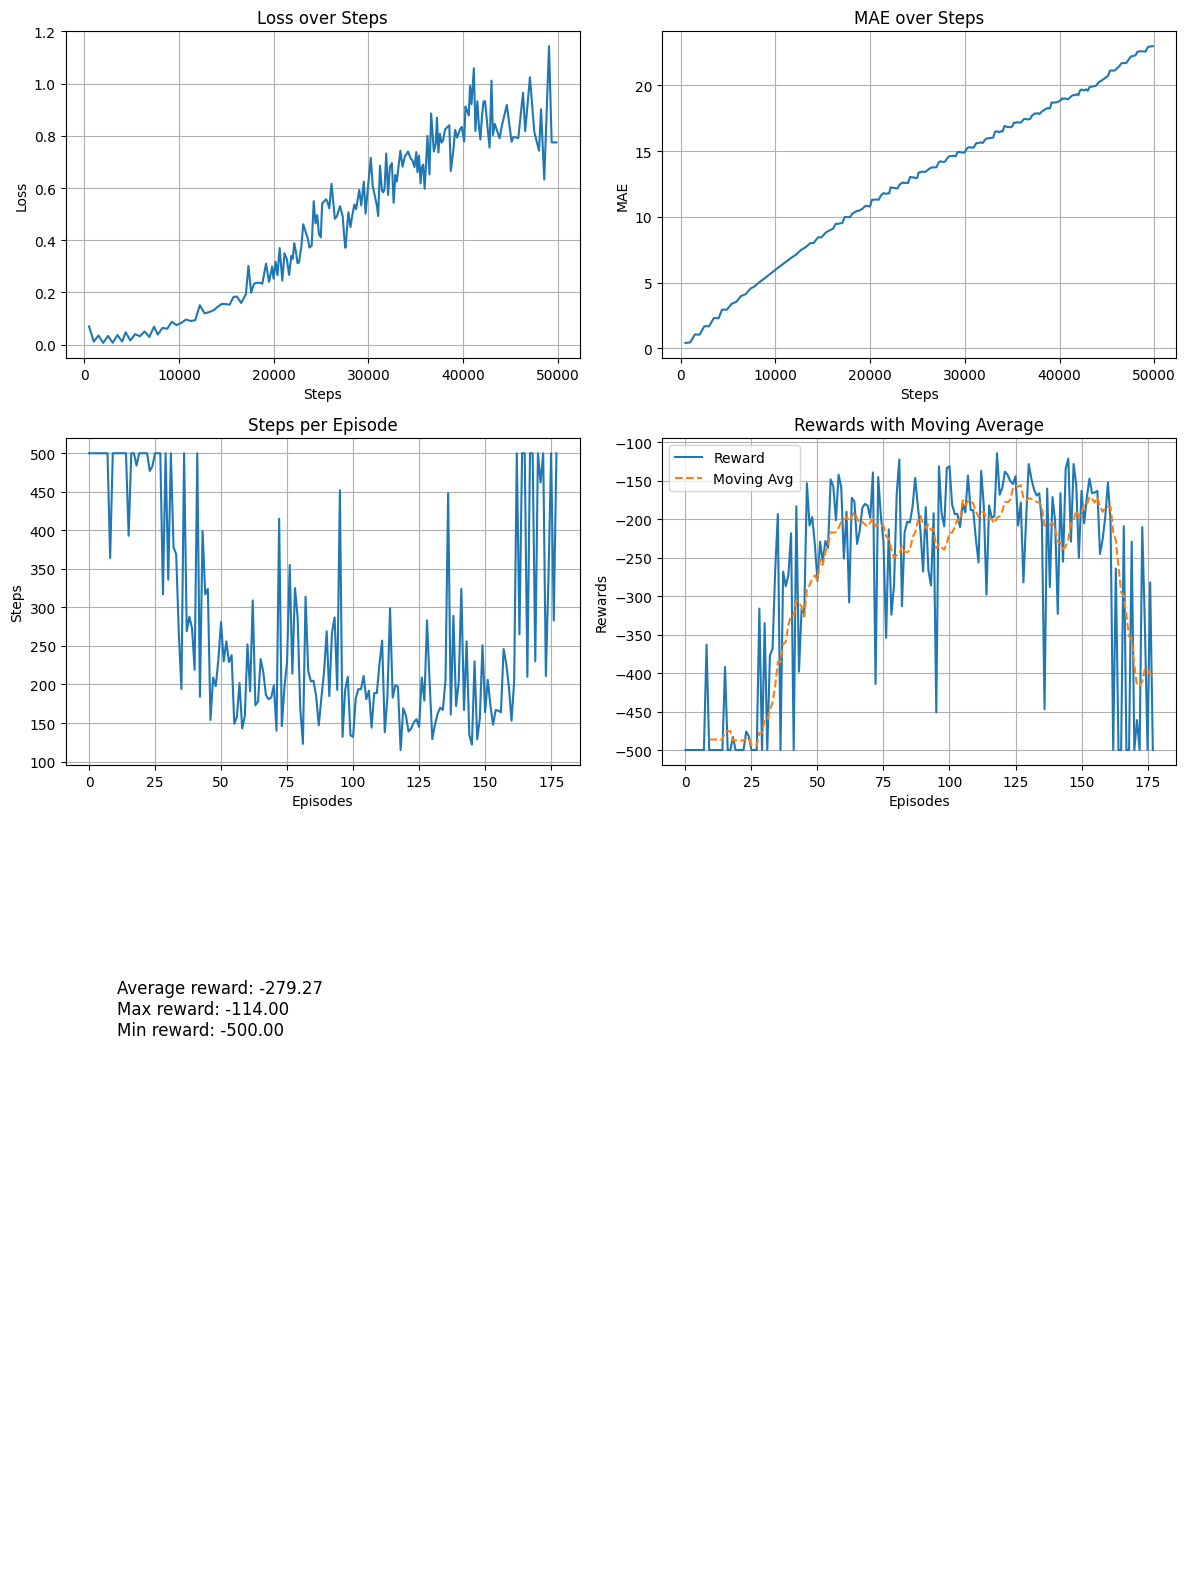

In [18]:
visualizar_log(log_filename)

---
### 1. Mejorar la solución base

Usaremos el módulo Optuna para hacer una serie de entrenamientos de una tacada y evaluar después los resultados, correclacionando cada uno de los parámetros que se han usado en Optuma con la recompensa obtenida. Limitamos el número de steps a 12500 para que acabe en un tiempo prudencial

In [28]:
import optuna
import time

class TimingCallback:
    def __init__(self, total_trials):
        self.start_time = None
        self.times = []
        self.total_trials = total_trials

    def __call__(self, study, trial):
        if self.start_time is None:
            self.start_time = time.time()

        # Calcular tiempo por ensayo
        elapsed_time = time.time() - self.start_time
        self.times.append(elapsed_time / len(self.times) if self.times else elapsed_time)
        estimated_remaining_time = (self.total_trials - len(study.trials)) * self.times[-1]
        
        print(f"Trial {len(study.trials)}/{self.total_trials} complete.")
        print(f"Time per trial: {self.times[-1]:.2f}s | Estimated time remaining: {estimated_remaining_time:.2f}s")

In [33]:
def objective(trial):

    nb_episodes = 5
    n_trials = 50
    
    memory_limit = 10000
    window_length = 4
    test_eps = 0.05
    steps_warmup = 100
    train_interval = 4
    nb_steps = 12500
    
    # Sugerir valores de hiperparámetros
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    gamma = trial.suggest_float('gamma', 0.9, 0.99)
    max_eps = trial.suggest_float('max_eps', 0.8, 1.0)  # Epsilon inicial
    min_eps = trial.suggest_float('min_eps', 0.01, 0.1)  # Epsilon final
    steps_exploration = trial.suggest_int('steps_exploration', 10000, 50000)
    target_model_update = trial.suggest_int('target_model_update', 500, 2000)    
    filters_layer1 = trial.suggest_categorical('filters_layer1', [16, 32, 64])
    filters_layer2 = trial.suggest_categorical('filters_layer2', [16, 32, 64])
    filters_layer3 = trial.suggest_categorical('filters_layer3', [16, 32, 64])

    # Crear modelo
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape),
        tf.keras.layers.Dense(filters_layer1, activation='relu'),
        tf.keras.layers.Dense(filters_layer2, activation='relu'),
        tf.keras.layers.Dense(filters_layer3, activation='relu'),
        tf.keras.layers.Dense(nb_actions, activation='linear'),
    ])
    
    # Crear memoria y política
    memory = SequentialMemory(limit=memory_limit, window_length=window_length)
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),
        attr='eps', value_max=max_eps, value_min=min_eps,
        value_test=test_eps, nb_steps=steps_exploration
    )
    
    # Crear agente
    dqn = DQNAgent(
        model=model,
        nb_actions=nb_actions,
        memory=memory,
        policy=policy,
        gamma=gamma,
        train_interval=train_interval,
        batch_size=batch_size,
    )
    
    dqn.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])
    
    # Entrenar y evaluar
    dqn.fit(env, nb_steps=nb_steps, visualize=False, verbose=0)
    rewards  = dqn.test(env, nb_episodes=nb_episodes, visualize=False)
    mean_reward = sum(rewards.history['episode_reward']) / len(rewards.history['episode_reward'])
    
    return mean_reward

# Crear estudio de Optuna
study = optuna.create_study(direction='maximize')

[I 2024-12-08 12:52:26,977] A new study created in memory with name: no-name-1b1d74be-bc07-49c5-9b4f-6acd61e71faf


In [ ]:
# Callback para estimar tiempo
timing_callback = TimingCallback(total_trials=50)
study.optimize(objective, n_trials=50, callbacks=[timing_callback])

In [71]:
print(f"Mejores hiperparámetros: {study.best_params}")
print(f"Mejor recompensa: {study.best_value}")

Mejores hiperparámetros: {'learning_rate': 0.008051418956069525, 'batch_size': 32, 'gamma': 0.9853246522040829, 'max_eps': 0.8962194534889183, 'min_eps': 0.09663233853405731, 'steps_exploration': 24569, 'target_model_update': 1999, 'filters_layer1': 64, 'filters_layer2': 64, 'filters_layer3': 64}
Mejor recompensa: -77.8


In [58]:
# Convertir ensayos a DataFrame
df = study.trials_dataframe()
df['filters_combined'] = df.apply(
    lambda row: row['params_filters_layer1']*row['params_filters_layer2']*row['params_filters_layer3'], 
    axis=1
)

# Guardar el DataFrame en un archivo CSV
csv_file = "study_trials.csv"
df.to_csv(csv_file, index=False)

print(f"Datos guardados en {csv_file}")

Datos guardados en study_trials.csv


In [59]:
# Filtrar solo columnas numéricas y eliminar -500
df = df[df["value"] != -500]
numeric_df = df.select_dtypes(include=[float, int])

Correlaciones con la recompensa:
number                       -0.045296
params_batch_size             0.034649
params_filters_layer1        -0.036186
params_filters_layer2         0.333344
params_filters_layer3         0.177184
params_gamma                  0.098711
params_learning_rate          0.088253
params_max_eps               -0.001071
params_min_eps               -0.079228
params_steps_exploration     -0.090012
params_target_model_update    0.002748
filters_combined              0.168617
Name: value, dtype: float64


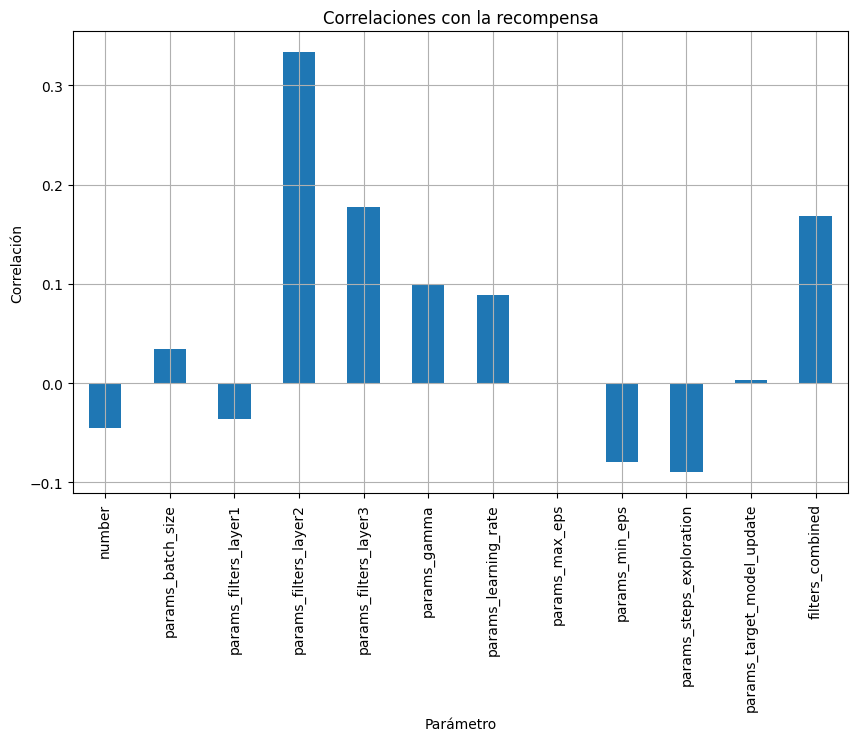

In [70]:
# Calcular la correlación entre las columnas numéricas
correlations = numeric_df.corr()["value"].drop("value")
print("Correlaciones con la recompensa:")
print(correlations)

# Gráfico de barras para visualizar correlaciones
correlations.plot(kind="bar", figsize=(10, 6), title="Correlaciones con la recompensa")
plt.xlabel("Parámetro")
plt.ylabel("Correlación")
plt.grid(True)
plt.show()


Se puede apreciar que los valores que más afectan a la recompensan son los filtros de la capa 2 y 3 (siendo más elevantes los de la capa 2), mientras que los de la capa 1 aparecen con correlación negativa, indicando que contra más bajos mejor. Esto nos lleva a eliminar la capa 1, e incrementar los filtros de la capa 2 (que pasará a ser la 1).

Aunque no se ha evaluado, es conocido que la memoria nunca está de más, por lo que la incrementamos considerablemente. Del mismo modo incrementaremos el steps_warmup para eliminar el warning.

Reduciremos el parámetro steps_exploration a la mitad, y dejaremos todo lo demás igual ya que no parecen tan significativos.

In [68]:
# Hyper-params anteriores
# memory_limit = 10000
# window_length = 4
# max_eps, min_eps, test_eps = 1.0, 0.1, 0.05
# steps_exploration = 25000
# steps_warmup = 100
# gamma = 0.99
# target_model_update = 1000
# train_interval = 4
# learning_rate = 1e-3
# nb_steps = 50000
# batch_size = 128

# Hyper-params
memory_limit = 1000000
window_length = 4
max_eps, min_eps, test_eps = 1.0, 0.1, 0.05
steps_exploration = 12500
steps_warmup = 500
gamma = 0.99
target_model_update = 1000
train_interval = 4
learning_rate = 1e-3
nb_steps = 50000
batch_size = 128

# Modelo simple
input_shape = (n_obs)
best_params_model = tf.keras.models.Sequential()
best_params_model.add(tf.keras.layers.Flatten(input_shape=(window_length,) + env.observation_space.shape))
#best_params_model.add(tf.keras.layers.Dense(16))
#best_params_model.add(tf.keras.layers.Activation('relu'))
best_params_model.add(tf.keras.layers.Dense(128))
best_params_model.add(tf.keras.layers.Activation('relu'))
best_params_model.add(tf.keras.layers.Dense(64))
best_params_model.add(tf.keras.layers.Activation('relu'))
best_params_model.add(tf.keras.layers.Dense(nb_actions))
best_params_model.add(tf.keras.layers.Activation('linear'))
print(best_params_model.summary())

# Memory
memory = SequentialMemory(limit=memory_limit, window_length=window_length)

# Policy
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=max_eps, value_min=min_eps,
                              value_test=test_eps, nb_steps=steps_exploration)
# Agente
best_params_egreed_dqn = DQNAgent(model=best_params_model, nb_actions=nb_actions,
               policy=policy, memory=memory,
               nb_steps_warmup=steps_warmup, gamma=gamma,
               target_model_update=target_model_update,
               train_interval=train_interval, batch_size=batch_size)

# Compilar
best_params_egreed_dqn.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mae'])

# Callbacks
model_name = 'best_params_'
# Guardar los mejores pesos
best_filename = f'best_{model_name}{env_name}_weights.h5f'
best_model_saver = BestModelSaver(
    filepath=best_filename,
    monitor='episode_reward',
    mode='max' 
)
# Guardar el log
log_filename = f'{model_name}{env_name}_log.json'
callbacks = [FileLogger(log_filename, interval=100), best_model_saver]

# Entrenar
best_params_egreed_dqn.fit(env, callbacks=callbacks, nb_steps=nb_steps, visualize=False, verbose=2)

# Salvar pesos finales
best_params_egreed_dqn.save_weights( f'final_{model_name}{env_name}_weights.h5f', overwrite=True)

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_77 (Flatten)        (None, 24)                0         
                                                                 
 dense_308 (Dense)           (None, 128)               3200      
                                                                 
 activation_44 (Activation)  (None, 128)               0         
                                                                 
 dense_309 (Dense)           (None, 64)                8256      
                                                                 
 activation_45 (Activation)  (None, 64)                0         
                                                                 
 dense_310 (Dense)           (None, 3)                 195       
                                                                 
 activation_46 (Activation)  (None, 3)               

C:\Users\david\anaconda3\envs\miar_rl\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Episode 0: episode_reward improved from -inf to -500.0000. Saving weights.
   500/50000: episode: 1, duration: 9.529s, episode steps: 500, steps per second:  52, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.066 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


C:\Users\david\anaconda3\envs\miar_rl\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  1000/50000: episode: 2, duration: 25.793s, episode steps: 500, steps per second:  19, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.038 [0.000, 2.000],  loss: 0.018256, mae: 0.301517, mean_q: -0.239799, mean_eps: 0.946000
  1500/50000: episode: 3, duration: 10.394s, episode steps: 500, steps per second:  48, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.996 [0.000, 2.000],  loss: 0.025912, mae: 0.945415, mean_q: -1.290487, mean_eps: 0.910144
  2000/50000: episode: 4, duration: 9.124s, episode steps: 500, steps per second:  55, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.944 [0.000, 2.000],  loss: 0.002325, mae: 0.908711, mean_q: -1.292239, mean_eps: 0.874144
  2500/50000: episode: 5, duration: 9.374s, episode steps: 500, steps per second:  53, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.914 [0.000, 2.000],  loss: 0.028605, mae: 1.605585, mean_q: -2.2

In [83]:
# Testear los mejores pesos
best_params_egreed_dqn.load_weights(f"final_{model_name}{env_name}_weights.h5f")
best_params_egreed_dqn.test(env, nb_episodes=20, visualize=False)

Testing for 20 episodes ...
Episode 1: reward: -96.000, steps: 97
Episode 2: reward: -74.000, steps: 75
Episode 3: reward: -89.000, steps: 90
Episode 4: reward: -79.000, steps: 80
Episode 5: reward: -72.000, steps: 73
Episode 6: reward: -77.000, steps: 78
Episode 7: reward: -78.000, steps: 79
Episode 8: reward: -72.000, steps: 73
Episode 9: reward: -90.000, steps: 91
Episode 10: reward: -99.000, steps: 100
Episode 11: reward: -81.000, steps: 82
Episode 12: reward: -92.000, steps: 93
Episode 13: reward: -101.000, steps: 102
Episode 14: reward: -104.000, steps: 105
Episode 15: reward: -96.000, steps: 97
Episode 16: reward: -113.000, steps: 114
Episode 17: reward: -82.000, steps: 83
Episode 18: reward: -89.000, steps: 90
Episode 19: reward: -108.000, steps: 109
Episode 20: reward: -82.000, steps: 83


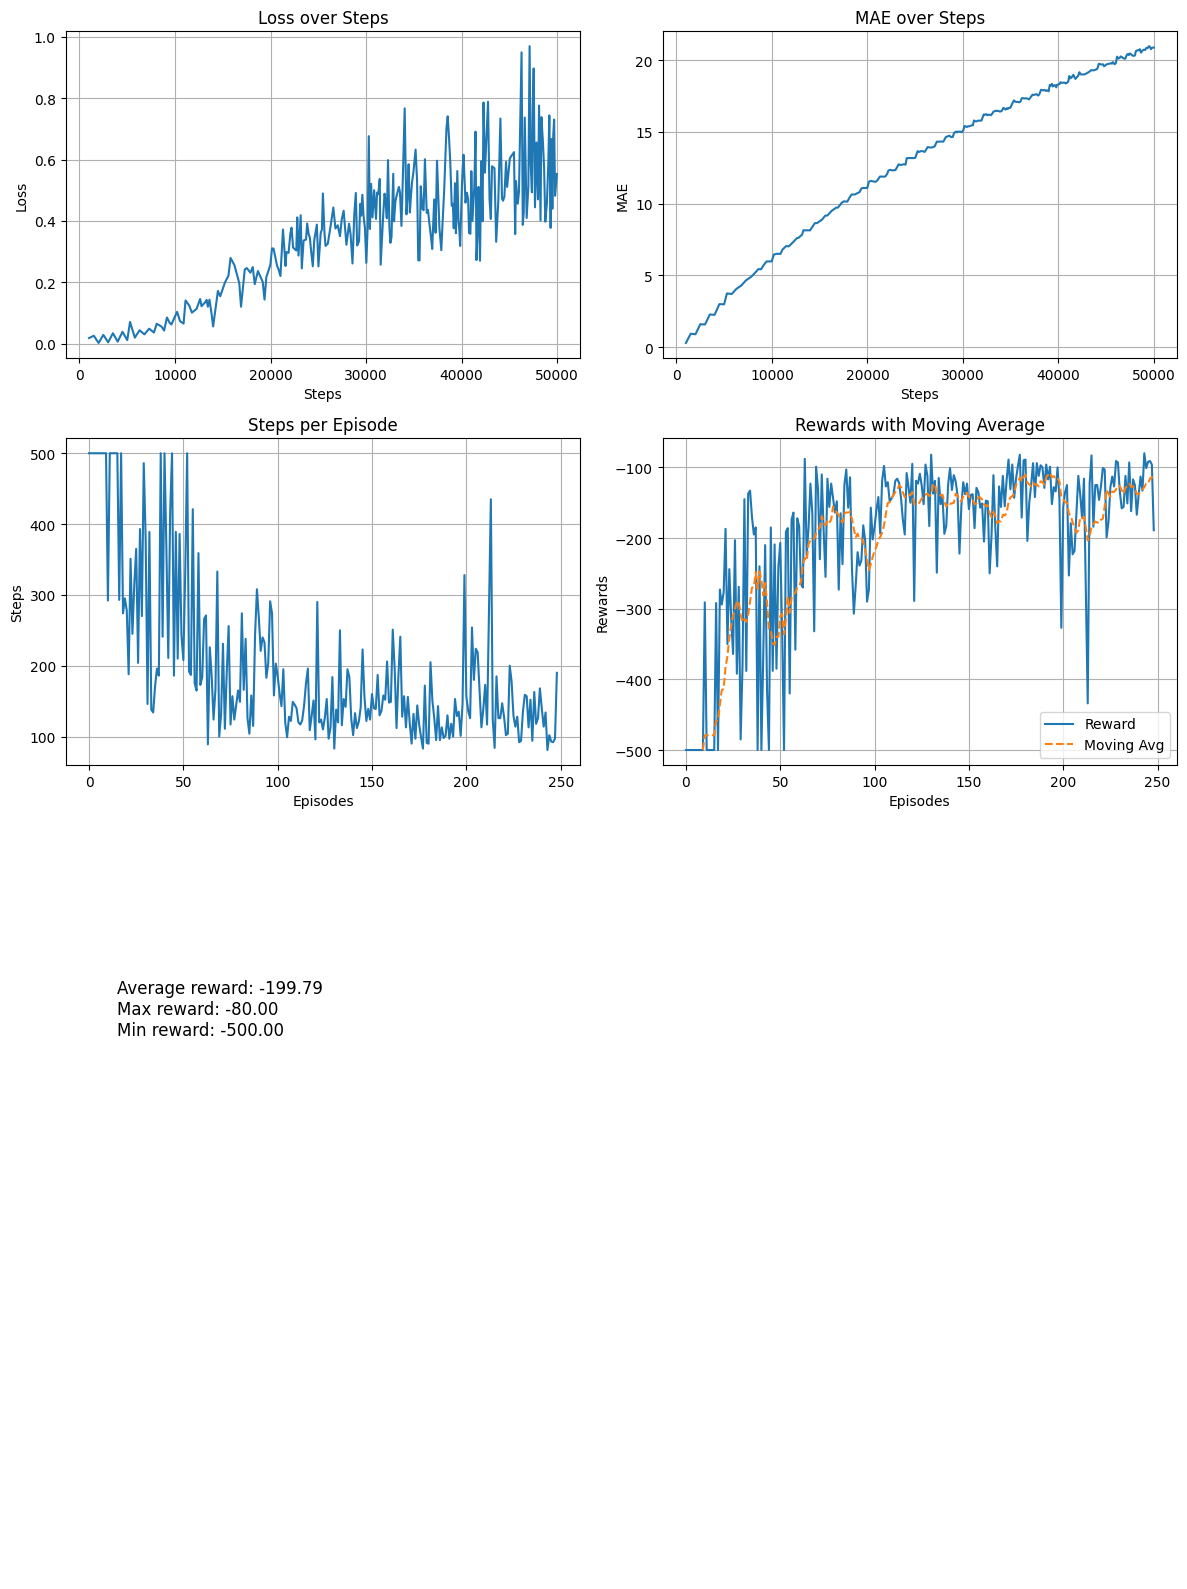

In [69]:
visualizar_log(log_filename)

Quizás se le podrían dar más steps para ver si seguía mejorando, pero los valores que han salido en test son suficientemente buenos, y mejores que el modelo baseline.

---
### 2. Investigar y presentar las diferencias de este agente con versiones más avanzadas.

% TOWRITE

---
### 3. Comparar, empleando keras-rl, el rendimiento de estos métodos más avanzados.

In [ ]:
# TODO

---
### 4. Exploración de hyper-parámetros. Discusión de los resultados.

In [ ]:
# TODO

---
### 5. Conclusiones y discusión

% TOWRITE